End to end procedure in detecting Sudoku boards

In [2]:
# Load all modules required to run program
import cv2
import numpy as np
from PIL import Image
from scipy.spatial import distance as dist
import os, sys, unittest
sys.path.append(os.path.abspath('..'))

In [6]:
# Load the 3 major classes created in this package to detect Sudoku boards and solve
from detection_class import SudokuDetector
from digit_recognition import DigitRecognizer
from solver import SudokuSolver

/Users/matthewgray/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
model_path = '../models/cnn_digit_recognition.h5'
sudokuDetector = SudokuDetector()
digitRecognizer = DigitRecognizer(model_path=model_path)
sudokuSolver = SudokuSolver()

In [9]:
# Path to the image for recognition
input_filepath = '../tests/ideal_image.jpg'

First step is to load the image:

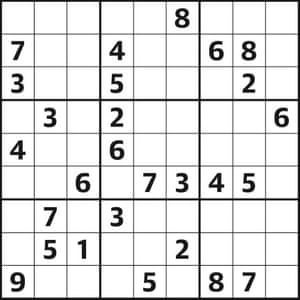

In [12]:
loaded_image = sudokuDetector._load_image(input_filepath)
Image.fromarray(loaded_image)

Next step is to add Gaussian blur to the image. This step removes detection problems as a result of sharp edges or sharp transitions in the image.

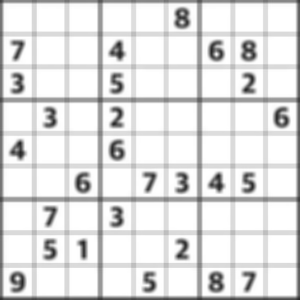

In [14]:
blurred_image = sudokuDetector._blur_image(loaded_image)
Image.fromarray(blurred_image)

After Gaussian blurring, the next step is to apply a threshold to convert the image from RGB to black and white. In order to compensate for variable lighting conditions (in the case the image comes from a camera with variable lighting on the Sudoku board), an adaptive threshold is used.

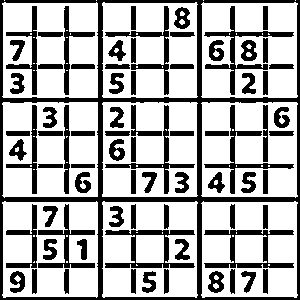

In [15]:
black_and_white_image = sudokuDetector._threshold_image(blurred_image)
Image.fromarray(black_and_white_image)

After the image is converted to black and white, the next step is to invert the image such that black is the background colour, and white is the 'object' colour for identification, as required by the OpenCV package.

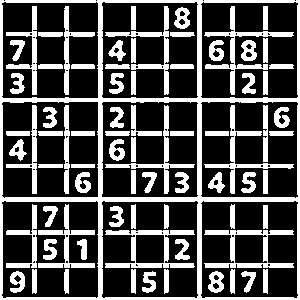

In [16]:
inverted_image = sudokuDetector._invert_image(black_and_white_image)
Image.fromarray(inverted_image)

The next major step in Sudoku board recognition is the determination of the Sudoku board in the image. As an assumption, we expect the Sudoku board to be the largest contour within a provided image. In order to reduce the amount of disconnectedness in the image that thresholding has caused, we use the dilate image transformation to help fill in tiny pixel gaps from lines that should be connected together.

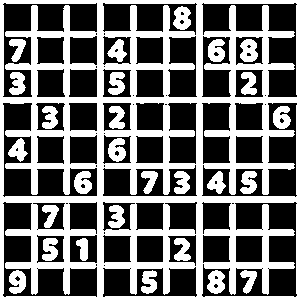

In [17]:
dilated_image = sudokuDetector._dilate_image(inverted_image)
Image.fromarray(dilated_image)

After the image has been dilated, the next step is to detect the contour in the image with the largest area. In a typical screenshot of a sudoku board, this represents a polygon connected by 4 points, which contains the largest total area. The warp transformation of the OpenCV library will warp the image, including stretching and rotation, such that we can most properly line up the image as a frontward facing, properly oriented angle; which has been scaled to a size well suited for the image recognition machine learning algorithm.

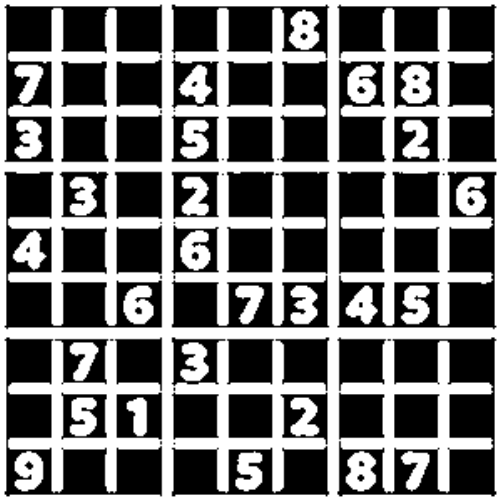

In [18]:
warped_image = sudokuDetector._warp_image(dilated_image)
Image.fromarray(warped_image)

Having set up a frontward facing, properly oriented image. The next step is to break down each square within the Sudoku board into an array of single squares representing the images of the digits in each position of the array.

This step is performed using the assumption that the board is perfectly divided into 9x9 tiles, where each tile is an extracted section from the original image array.

Row 2 : Column 1


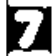

In [24]:
board_array = sudokuDetector._segment_image(warped_image)

# Sample the second row (Python index 1) first column (Python index 0)
# to verify that the image of a 7 exists in the array we have created
row_index = 1
column_index = 0

print('Row ' + str(row_index+1) + ' : Column ' + str(column_index+1))
Image.fromarray(board_array[row_index][column_index])

Row 9 : Column 1


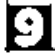

In [27]:
# Verify bottom left corner is 9
row_index = 8
column_index = 0

print('Row ' + str(row_index+1) + ' : Column ' + str(column_index+1))
Image.fromarray(board_array[row_index][column_index])

The output of the sudokuDetector module is the board_array, where each element of the array is an image array as shown above. The next step is to invoke the digit_recognition object to convert each image in the baord_array into an integer representing the value 1-9 (or 0 if no digit is detected).

DIGIT RECOGNITION START

Digit recognition is a two stage process, due to the MNIST CNN model not picking out spaces without digits.

Step 1: Identify whether or not the sudoku square contains a digit (If no digit, set to 0)
Step 2: If a digit exists in the image, pass the image through the pre-trained machine learning model

In order to determine whether or not a digit exists in the image, the image is cropped to remove the white line boundary. Next, the number of white pixels are counted in the cropped image and applied to a fixed threshold. If enough white pixels are found in the cropped form of the image, the image is assumed to contain a digit which requires recognition, otherwise no digit is assumed to be in the image and the digit recognizer returns a value of 0.

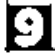

In [28]:
# Test the digit recognition algorithm on the number 9 from the bottom left of the example sudoku board above
row_index = 8
column_index = 0

sample_digit = board_array[row_index][column_index]
Image.fromarray(sample_digit)

In [29]:
# Crop the image to remove the white boundaries on the edge of the image
cropped_digit = digitRecognizer._crop_image(sample_digit)
Image.fromarray(cropped_digit)

In [30]:
# Is the image empty enough to be considered as a blank space
digitRecognizer._is_zero(sample_digit)

False

In [31]:
# The digit itself needs to be eroded and resized to 28x28 pixels to more closely
# match the training data of the CNN model trained on MNIST data

# Erosion thins out the thick white lines of the image
# Resizing to 28x28 is due to the input requirements of the machine learning model

transformed_digit = digitRecognizer._transform_digit_image(sample_digit)
Image.fromarray(transformed_digit)

In [33]:
# Pass the resized image through the machine learning model to get the results
scored_digit = digitRecognizer._score_digit(sample_digit)
print('Digit predictied: ' + str(scored_digit))

Digit predictied: 9


The recognize_board function from the digit recognizer applies the detection algorithm to every element in the array, replacing the images with the digits determined.

In [43]:
recognized_board = digitRecognizer.recognize_board(board_array)

# Cast output as a numpy array to better view in console
print(np.array(recognized_board))

[[0. 0. 0. 0. 0. 8. 0. 0. 0.]
 [7. 0. 0. 4. 0. 0. 6. 8. 0.]
 [3. 0. 0. 5. 0. 0. 0. 2. 0.]
 [0. 3. 0. 2. 0. 0. 0. 0. 6.]
 [4. 0. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 6. 0. 7. 3. 4. 5. 0.]
 [0. 7. 0. 3. 0. 0. 0. 0. 0.]
 [0. 5. 1. 0. 0. 2. 0. 0. 0.]
 [9. 0. 0. 0. 5. 0. 8. 7. 0.]]


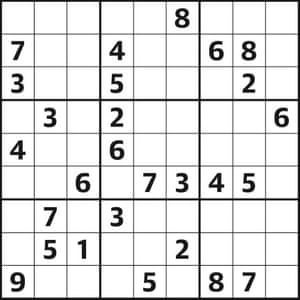

In [44]:
# Show original board for reference to above recognized board
Image.fromarray(loaded_image)

The final step is to solve the game board in its recognized state using the solver class

In [46]:
recognized_board = digitRecognizer.recognize_board(board_array)
solved_board = sudokuSolver.solveSudoku(recognized_board)
print(np.array(solved_board))

[[1. 6. 5. 9. 2. 8. 3. 4. 7.]
 [7. 2. 9. 4. 3. 1. 6. 8. 5.]
 [3. 8. 4. 5. 6. 7. 1. 2. 9.]
 [5. 3. 8. 2. 1. 4. 7. 9. 6.]
 [4. 1. 7. 6. 9. 5. 2. 3. 8.]
 [2. 9. 6. 8. 7. 3. 4. 5. 1.]
 [6. 7. 2. 3. 8. 9. 5. 1. 4.]
 [8. 5. 1. 7. 4. 2. 9. 6. 3.]
 [9. 4. 3. 1. 5. 6. 8. 7. 2.]]
